In [1]:
import os
import sys
import math
import pandas as pd
import numpy as np
import time
import torch
from tqdm import tqdm, trange
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [3]:
sys.path.append("./bin")
from dataset import SmilesEncoder
from gumbel import GumbelSmilesVAE
from rewards import RewardQED, RewardPenalizedLogP

In [4]:
output_dir = "output_2_pretrain_GumbelSmilesVAE_ZINC"

In [5]:
filepath_tokenizer = os.path.join(output_dir, "char2idx.csv")

tokenizer = SmilesEncoder(filepath_tokenizer)

Vocabulary size (including 3 special tokens): 28


In [6]:
generator = GumbelSmilesVAE(vocab_size=tokenizer.vocab_size,
                      embedding_size=16,
                      hidden_size=256,
                      latent_size=64,
                      sos_idx=tokenizer.sos_idx,
                      eos_idx=tokenizer.eos_idx,
                      pad_idx=tokenizer.pad_idx,
                      device=device)

filepath_model = os.path.join(output_dir, "SmilesVAE.pt")
generator.load_model(filepath_model)

In [7]:
rng = np.random.RandomState(2021)
latent_vectors = (rng.randn(10,64) > 0).astype(np.float32)

In [ ]:
df_z = pd.DataFrame(latent_vectors)

In [8]:
smiles_per_z = []
n_generate = 1000

with torch.no_grad():
    for z in latent_vectors:
        z = torch.cuda.FloatTensor(z, device=device)
        smiles = []
        for _ in trange(n_generate):
            smi = generator.inference(z)
            smi = tokenizer.decode([smi])[0]
            smiles.append(smi)
        smiles_per_z.append(smiles)

100%|██████████| 1000/1000 [00:31<00:00, 31.69it/s]


In [9]:
calc_qed = RewardQED() # qed = calc_qed(smi, debug=True)[1]
calc_logp = RewardPenalizedLogP() # _, clogp, sascore, numring, penalizedlogp = calc_logp(smi, debug=True)

In [52]:
frames = []

for i, smiles in enumerate(smiles_per_z):
    scores = {"LogP":[], "SAscore":[], "PenalizedLogP":[], "QED":[]}
    for smi in smiles:
        qed = calc_qed(smi, debug=True)[1]
        _, clogp, sascore, numring, penalizedlogp = calc_logp(smi, debug=True)
        scores["QED"].append(qed)
        scores["SAscore"].append(sascore)
        scores["PenalizedLogP"].append(penalizedlogp)
        scores["LogP"].append(clogp)
    df = pd.DataFrame.from_dict(scores)
    df["SMILES"] = smiles
    df["latent_vector"] = i
    frames.append(df)

In [58]:
df_merge = pd.concat(frames, ignore_index=True)
df_merge.to_csv(os.path.join(output_dir, "pointwise_distribution_ZINC.csv"), index=False)
df_merge.head()

,LogP,SAscore,PenalizedLogP,QED,SMILES,latent_vector
0,2.36600,2.352760,0.013240,0.597887,COC(=O)C(C)(C)CN(C)C(=O)C=CC1=CC=C(OC)C=C1,0
1,1.56620,2.891972,-1.325772,0.748001,COC(=O)C(CC(=O)N1CC=C(C2=CC=CC=C2)CC1)N1CCOCC1,0
2,2.80240,2.386632,0.415768,0.619837,COC(=O)C(C)(C)CNC(=O)C=CC1=CC=CC(OC(C)C)=C1,0
3,0.97677,3.068014,-2.091244,0.651098,COC(=O)C(C)(C)CN1C(=O)C(C#N)=CNC1=S,0
4,0.55720,3.687092,-3.129892,0.761349,COC(=O)C(C)NC(=O)C(OC)(C1=CC=CS1)N1CCOCC1,0


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from umap import UMAP
sns.set_theme(style="whitegrid")

In [13]:
points = PCA(n_components=2, random_state=2021).fit_transform(latent_vectors)
#points = UMAP(metric="euclidean", n_components=2, random_state=2021).fit_transform(latent_vectors)

In [59]:
df_points = pd.DataFrame(points, columns=["PC1", "PC2"])
df_points = df_points.merge(df_z, left_index=True, right_index=True)
df_points.to_csv(os.path.join(output_dir, "pointwise_pca_ZINC.csv"), index=False)
df_points.head()

,PC1,PC2,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
0,-2.025045,2.315542,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1,-1.252773,0.948007,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,-1.493287,0.133618,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.272129,-1.269085,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
4,2.387399,-1.090637,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


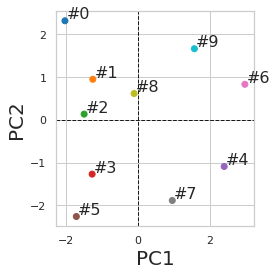

In [60]:
fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.scatter(points[:,0], points[:,1], c=np.arange(len(points)), cmap=plt.get_cmap("tab10"))

for i in range(len(points)):
    ax.text(x=points[i,0]+0.05, y=points[i,1]+0.05, s=f"#{i}", fontsize=16)

ax.axvline(x=0, c='k', linestyle='--', linewidth=1)
ax.axhline(y=0, c='k', linestyle='--', linewidth=1)
ax.set_xlabel("PC1", fontsize=20)
ax.set_ylabel("PC2", fontsize=20)

plt.tight_layout()
plt.savefig(os.path.join("figures", "PCA_GumbelSmilesVAE_ZINC.png"), dpi=300)
plt.show()

In [61]:
def show_kde(df, target_col, drop_zero=False, filepath=None):
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    if drop_zero:
        sns.kdeplot(data=df[df[target_col] != 0.], x=target_col, hue="latent_vector", ax=ax, palette="tab10")
    else:
        sns.kdeplot(data=df, x=target_col, hue="latent_vector", ax=ax)
    
    #ax.set_title(target_col, fontsize=28)
    ax.set_xlabel(target_col, fontsize=20)
    ax.legend().set_visible(False)
    
    plt.tight_layout()
    plt.savefig(filepath, dpi=300)
    plt.show()

No handles with labels found to put in legend.


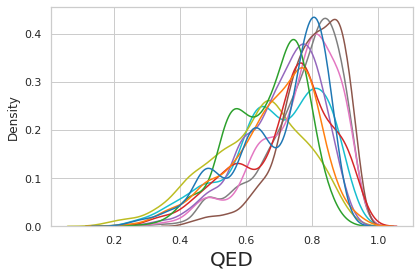

No handles with labels found to put in legend.


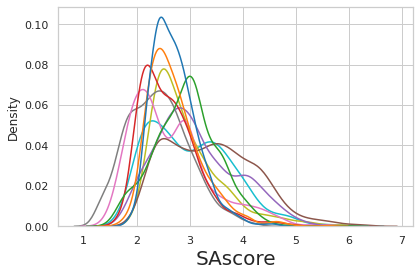

No handles with labels found to put in legend.


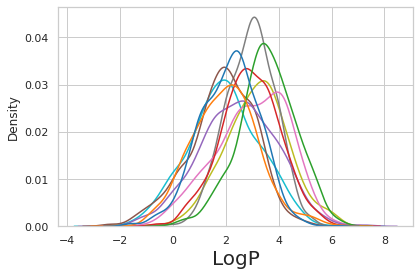

In [62]:
show_kde(df_merge, "QED", drop_zero=True, filepath=os.path.join("figures", "pointwise_distribution_GumbelSmilesVAE_ZINC_qed.png"))
show_kde(df_merge, "SAscore", drop_zero=True, filepath=os.path.join("figures", "pointwise_distribution_GumbelSmilesVAE_ZINC_sascore.png"))
show_kde(df_merge, "LogP", drop_zero=True, filepath=os.path.join("figures", "pointwise_distribution_GumbelSmilesVAE_ZINC_logp.png"))